# Karate Club Network Analysis

This notebook analyzes Zachary's Karate Club network to identify influential members, detect factions, and test network resilience.

## Executive Summary

**Business question:** If you are managing a club or customer community, which members most influence cohesion, and how vulnerable is the group to losing key people?

**Why it matters:** Identifying high-impact members helps prioritize engagement and retention, while resilience analysis shows how quickly the community fragments under random churn versus targeted loss.

**What this analysis delivers:** A ranked view of influential members, a validated faction split, and a resilience profile that highlights where intervention prevents fragmentation.

## Phase 1: Data Loading and Exploration

Load the built-in Karate Club graph and summarize core statistics and faction counts.

In [77]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, normalized_mutual_info_score
from IPython.display import Markdown, display

RANDOM_SEED = 42
MAX_REMOVE = 17
RANDOM_TRIALS = 100
NODE_SIZE_SCALE = 80
FIGSIZE_HEATMAP = (7, 5)
FIGSIZE_RESILIENCE = (10, 4)
FIGSIZE_NETWORK = (7, 5)
FIGSIZE_SCATTER = (6, 4)

np.random.seed(RANDOM_SEED)

# Load the Karate Club graph and compute basic summary metrics.
G = nx.karate_club_graph()

num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

degrees = dict(G.degree())
avg_degree = sum(degrees.values()) / num_nodes

density = nx.density(G)

MrHi_nodes = [n for n in G if G.nodes[n]["club"] == "Mr. Hi"]
Officer_nodes = [n for n in G if G.nodes[n]["club"] == "Officer"]

summary = pd.DataFrame(
    {
        "metric": [
            "nodes",
            "edges",
            "avg_degree",
            "density",
            "mr_hi_count",
            "officer_count",
        ],
        "value": [
            num_nodes,
            num_edges,
            avg_degree,
            density,
            len(MrHi_nodes),
            len(Officer_nodes),
        ],
    }
)

summary

,metric,value
0,nodes,34.000000
1,edges,78.000000
2,avg_degree,4.588235
3,density,0.139037
4,mr_hi_count,17.000000
5,officer_count,17.000000


**Business interpretation:** This baseline quantifies the size and density of the community so later influence and resilience results can be translated into operational impact (how many members are at risk and how tightly connected they are).

## Phase 2: Centrality Analysis

Compute multiple centrality measures and identify top influencers across metrics.

In [78]:
def compute_all_centralities(G):
    """Compute a set of centrality measures for the graph."""
    return {
        "degree_centrality": nx.degree_centrality(G),
        "weighted_degree": dict(G.degree(weight="weight")),
        "betweenness": nx.betweenness_centrality(G),
        "closeness": nx.closeness_centrality(G),
        "eigenvector": nx.eigenvector_centrality(G, max_iter=1000),
        "pagerank": nx.pagerank(G),
    }


def top_n_table(df, n=5):
    rows = {}
    for col in df.columns:
        top = df[col].sort_values(ascending=False).head(n)
        rows[col] = [f"{idx} ({val:.4f})" for idx, val in top.items()]
    return pd.DataFrame(rows, index=range(1, n + 1))


# Centrality matrix and top influencers per metric.
centralities = compute_all_centralities(G)
centrality_df = pd.DataFrame(centralities)

top5_table = top_n_table(centrality_df, n=5)
top5_table

,degree_centrality,weighted_degree,betweenness,closeness,eigenvector,pagerank
1,33 (0.5152),33 (48.0000),0 (0.4376),0 (0.5690),33 (0.3734),33 (0.0970)
2,0 (0.4848),0 (42.0000),33 (0.3041),2 (0.5593),0 (0.3555),0 (0.0885)
3,32 (0.3636),32 (38.0000),32 (0.1452),33 (0.5500),2 (0.3172),32 (0.0759)
4,2 (0.3030),2 (33.0000),2 (0.1437),31 (0.5410),32 (0.3087),2 (0.0628)
5,1 (0.2727),1 (29.0000),31 (0.1383),13 (0.5156),1 (0.2660),1 (0.0574)


### Phase 2 Extension: Structural Holes and Correlation

Use Burt's constraint to highlight brokerage positions and compare degree vs betweenness correlation.

In [79]:
# Burt's constraint highlights brokerage/structural hole positions.
constraint_series = pd.Series(nx.constraint(G), name="constraint")
constraint_table = (
    constraint_series.sort_values()
    .head(5)
    .reset_index()
    .rename(columns={"index": "node"})
)

# Correlation between degree and betweenness centrality.
degree_betweenness_corr = centrality_df[["degree_centrality", "betweenness"]].corr().iloc[0, 1]

constraint_table, degree_betweenness_corr

(   node  constraint
 0     0    0.155423
 1    33    0.156419
 2     2    0.185177
 3    31    0.244575
 4    32    0.249223,
 np.float64(0.9146430315025843))

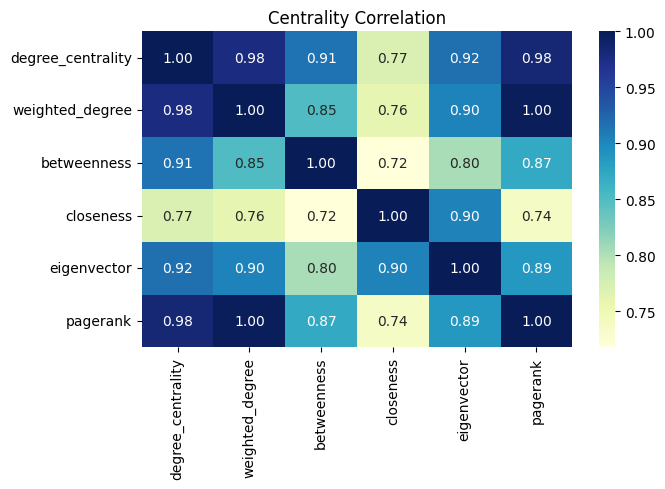

In [80]:
# Compare how different centrality measures move together.
corr = centrality_df.corr()

plt.figure(figsize=FIGSIZE_HEATMAP)
sns.heatmap(corr, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Centrality Correlation")
plt.tight_layout()
plt.show()

**Business interpretation:** The highest centrality members are the most efficient channels for influence and intervention. Strong correlation between degree and betweenness suggests simple degree-based targeting may be sufficient for engagement or risk mitigation in this network.

## Phase 3: Community Detection

Detect communities, quantify modularity, and compare detected groups with true factions.

In [81]:
# Detect two communities and compare them to the known faction labels.
communities = list(nx.community.greedy_modularity_communities(G, best_n=2))
community_map = {}
for idx, community in enumerate(communities):
    for node in community:
        community_map[node] = idx

modularity = nx.community.modularity(G, communities)

nodes_sorted = sorted(G.nodes())
true_labels = [0 if G.nodes[n]["club"] == "Mr. Hi" else 1 for n in nodes_sorted]
pred_labels = [community_map[n] for n in nodes_sorted]

nmi = normalized_mutual_info_score(true_labels, pred_labels)

acc_direct = accuracy_score(true_labels, pred_labels)
acc_flipped = accuracy_score(true_labels, [1 - label for label in pred_labels])
accuracy = max(acc_direct, acc_flipped)

community_table = pd.DataFrame(
    {
        "node": nodes_sorted,
        "club": [G.nodes[n]["club"] for n in nodes_sorted],
        "community": pred_labels,
    }
)

modularity, nmi, accuracy, community_table.head(10)

(0.3998332115215232,
 0.6772430411026017,
 0.9411764705882353,
    node     club  community
 0     0   Mr. Hi          0
 1     1   Mr. Hi          0
 2     2   Mr. Hi          0
 3     3   Mr. Hi          0
 4     4   Mr. Hi          0
 5     5   Mr. Hi          0
 6     6   Mr. Hi          0
 7     7   Mr. Hi          0
 8     8   Mr. Hi          1
 9     9  Officer          0)

**Business interpretation:** The detected communities align with the known factions, meaning the network structure alone can reveal group splits. This supports using network signals to anticipate churn or conflict and to tailor communications by subgroup.

## Phase 4: Network Metrics and Subgraph Comparison

Compare global and faction subgraph metrics to understand structural differences.

In [82]:
def compute_graph_metrics(G):
    """Compute graph-level metrics, using the largest component if disconnected."""
    connected = nx.is_connected(G)
    H = G
    if not connected:
        largest = max(nx.connected_components(G), key=len)
        H = G.subgraph(largest).copy()
    return {
        "nodes": G.number_of_nodes(),
        "edges": G.number_of_edges(),
        "density": nx.density(G),
        "avg_clustering": nx.average_clustering(G),
        "avg_shortest_path": nx.average_shortest_path_length(H),
        "diameter": nx.diameter(H),
        "connected": connected,
        "component_size": H.number_of_nodes(),
    }


# Compare full network with faction subgraphs.
metrics_full = compute_graph_metrics(G)
metrics_mrhi = compute_graph_metrics(G.subgraph(MrHi_nodes).copy())
metrics_officer = compute_graph_metrics(G.subgraph(Officer_nodes).copy())

metrics_table = pd.DataFrame(
    [metrics_full, metrics_mrhi, metrics_officer],
    index=["full", "mr_hi", "officer"],
)

metrics_table

,nodes,edges,density,avg_clustering,avg_shortest_path,diameter,connected,component_size
full,34,78,0.139037,0.570638,2.408200,5,True,34
mr_hi,17,35,0.257353,0.721569,1.823529,3,True,17
officer,17,32,0.235294,0.631279,1.889706,3,True,17


**Business interpretation:** Differences in clustering and path length between factions signal varying internal cohesion. The tighter group is easier to mobilize but also more vulnerable to targeted departures, while a looser group may need broader engagement to sustain connectivity.

## Phase 5: Robustness Simulation

Simulate random failures and targeted removals to assess resilience and fragmentation.

In [83]:
def largest_component_metrics(G, total_nodes):
    if G.number_of_nodes() == 0:
        return 0.0, 0.0, 0
    components = list(nx.connected_components(G))
    largest = max(components, key=len)
    H = G.subgraph(largest).copy()
    lcc_fraction = len(largest) / total_nodes
    if H.number_of_nodes() <= 1:
        avg_path = 0.0
    else:
        avg_path = nx.average_shortest_path_length(H)
    return lcc_fraction, avg_path, len(components)


def simulate_removal(G, mode="random", trials=100, max_remove=None):
    """Simulate node removal and return metric curves by k."""
    total_nodes = G.number_of_nodes()
    if max_remove is None:
        max_remove = total_nodes // 2
    max_remove = min(max_remove, total_nodes - 1)

    lcc_curve = []
    avg_path_curve = []
    component_curve = []
    nodes = list(G.nodes())

    if mode == "random":
        for k in range(1, max_remove + 1):
            lcc_vals = []
            avg_vals = []
            comp_vals = []
            for _ in range(trials):
                removed = set(np.random.choice(nodes, size=k, replace=False))
                H = G.copy()
                H.remove_nodes_from(removed)
                lcc, avg_path, comps = largest_component_metrics(H, total_nodes)
                lcc_vals.append(lcc)
                avg_vals.append(avg_path)
                comp_vals.append(comps)
            lcc_curve.append(float(np.mean(lcc_vals)))
            avg_path_curve.append(float(np.mean(avg_vals)))
            component_curve.append(float(np.mean(comp_vals)))
        return lcc_curve, avg_path_curve, component_curve

    if mode == "targeted":
        H = G.copy()
        for _ in range(1, max_remove + 1):
            betweenness = nx.betweenness_centrality(H)
            target = max(betweenness, key=betweenness.get)
            H.remove_node(target)
            lcc, avg_path, comps = largest_component_metrics(H, total_nodes)
            lcc_curve.append(lcc)
            avg_path_curve.append(avg_path)
            component_curve.append(comps)
        return lcc_curve, avg_path_curve, component_curve

    raise ValueError("mode must be 'random' or 'targeted'")

In [84]:
# Simulate random failures vs targeted removals.
random_lcc, random_avg_path, random_components = simulate_removal(
    G, mode="random", trials=RANDOM_TRIALS, max_remove=MAX_REMOVE
)
targeted_lcc, targeted_avg_path, targeted_components = simulate_removal(
    G, mode="targeted", max_remove=MAX_REMOVE
)

resilience_table = pd.DataFrame(
    {
        "k_removed": list(range(1, MAX_REMOVE + 1)),
        "random_lcc": random_lcc,
        "random_avg_path": random_avg_path,
        "random_components": random_components,
        "targeted_lcc": targeted_lcc,
        "targeted_avg_path": targeted_avg_path,
        "targeted_components": targeted_components,
    }
)

resilience_table.head()

,k_removed,random_lcc,random_avg_path,random_components,targeted_lcc,targeted_avg_path,targeted_components
0,1,0.965294,2.407410,1.06,0.794118,2.279202,3
1,2,0.930294,2.419313,1.13,0.764706,2.590769,3
2,3,0.887941,2.418029,1.31,0.588235,2.805263,8
3,4,0.862353,2.439011,1.28,0.294118,2.022222,10
4,5,0.824706,2.435271,1.39,0.235294,2.214286,14


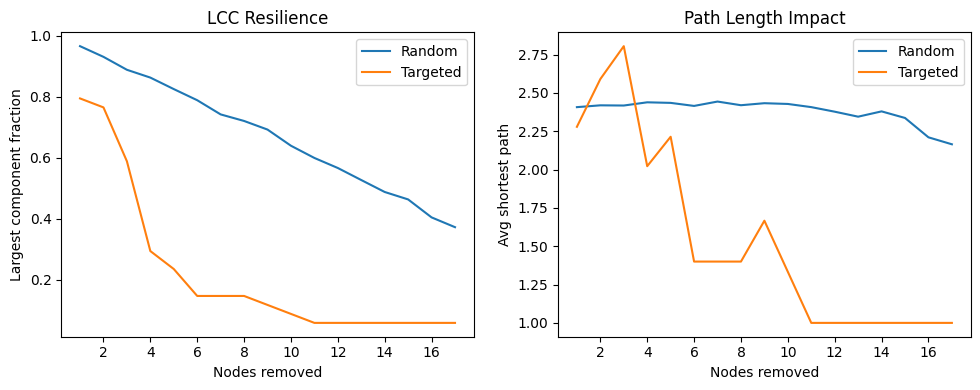

In [85]:
fig, axes = plt.subplots(1, 2, figsize=FIGSIZE_RESILIENCE)

axes[0].plot(resilience_table["k_removed"], resilience_table["random_lcc"], label="Random")
axes[0].plot(resilience_table["k_removed"], resilience_table["targeted_lcc"], label="Targeted")
axes[0].set_xlabel("Nodes removed")
axes[0].set_ylabel("Largest component fraction")
axes[0].set_title("LCC Resilience")
axes[0].legend()

axes[1].plot(
    resilience_table["k_removed"], resilience_table["random_avg_path"], label="Random"
)
axes[1].plot(
    resilience_table["k_removed"], resilience_table["targeted_avg_path"], label="Targeted"
)
axes[1].set_xlabel("Nodes removed")
axes[1].set_ylabel("Avg shortest path")
axes[1].set_title("Path Length Impact")
axes[1].legend()

plt.tight_layout()
plt.show()

**Business interpretation:** Targeted removals degrade the network faster than random churn, indicating a small set of members disproportionately sustain connectivity. Retention efforts should prioritize those individuals to prevent rapid fragmentation.

## Phase 6: Visualization

Visualize the network, centrality relationships, and robustness curves.

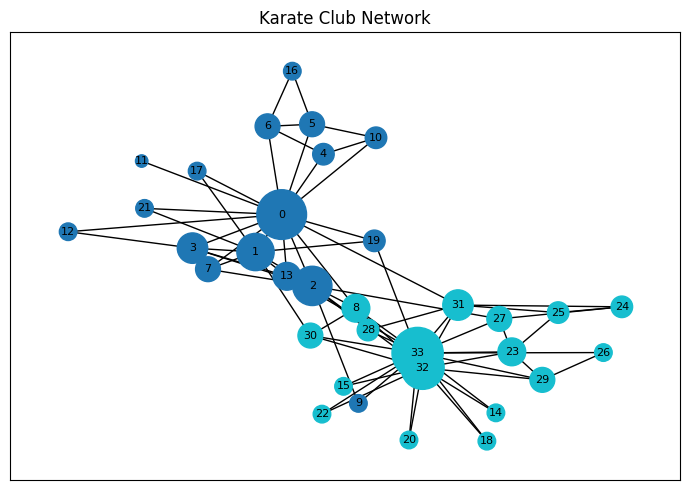

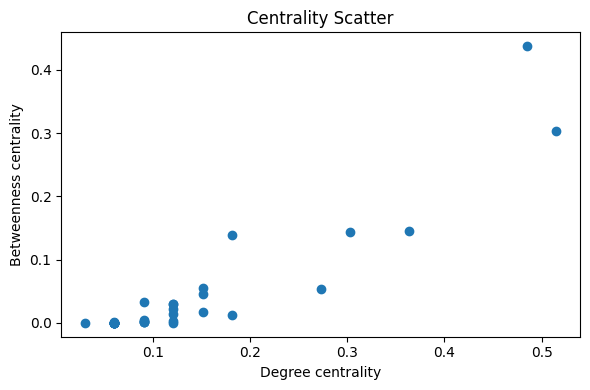

In [86]:
# Visualize the network colored by detected communities.
pos = nx.spring_layout(G, seed=RANDOM_SEED)
node_sizes = [degrees[n] * NODE_SIZE_SCALE for n in G.nodes()]
node_colors = [community_map[n] for n in G.nodes()]

plt.figure(figsize=FIGSIZE_NETWORK)
nx.draw_networkx(
    G,
    pos=pos,
    node_size=node_sizes,
    node_color=node_colors,
    cmap="tab10",
    with_labels=True,
    font_size=8,
)
plt.title("Karate Club Network")
plt.tight_layout()
plt.show()

# Compare degree centrality with betweenness centrality.
plt.figure(figsize=FIGSIZE_SCATTER)
plt.scatter(centrality_df["degree_centrality"], centrality_df["betweenness"])
plt.xlabel("Degree centrality")
plt.ylabel("Betweenness centrality")
plt.title("Centrality Scatter")
plt.tight_layout()
plt.show()

## Key Insights and Recommendations

- Focus engagement on the top centrality members; they are the fastest levers for influence and stability.
- Use community structure to tailor messaging and reduce cross-group friction.
- Monitor shifts in betweenness or constraint for early warning of fragmentation risk.
- Prioritize retention of high-betweenness nodes to prevent sharp drops in connectivity.

In [87]:
summary_text = f"""
## Summary

- Dataset: {num_nodes} nodes, {num_edges} edges, average degree {avg_degree:.2f}, density {density:.3f}; factions split {len(MrHi_nodes)}/{len(Officer_nodes)} (Mr. Hi vs Officer).
- Centrality results: degree and betweenness are strongly correlated (r ~= {degree_betweenness_corr:.3f}); top brokerage (lowest constraint) nodes include {", ".join(map(str, constraint_table["node"].head(2)))}.
- Community detection: greedy modularity finds {len(communities)} groups with modularity ~= {modularity:.3f}, NMI ~= {nmi:.3f}, and best-label accuracy ~= {accuracy:.2f} against true factions.
- Structural comparison: faction subgraphs show different clustering/path-length profiles compared with the full network (see metrics table), indicating distinct internal cohesion.
- Robustness: random removals reduce the largest component gradually (first step LCC {random_lcc[0]:.2f}), while targeted removals fragment the network faster (first step LCC {targeted_lcc[0]:.2f}); path lengths shift under targeted attack.
- Figures: centrality correlation heatmap, network layout colored by communities, degree vs betweenness scatter, and resilience/path-length curves visualize influence structure and fragility.
"""

display(Markdown(summary_text))


## Summary

- Dataset: 34 nodes, 78 edges, average degree 4.59, density 0.139; factions split 17/17 (Mr. Hi vs Officer).
- Centrality results: degree and betweenness are strongly correlated (r ~= 0.915); top brokerage (lowest constraint) nodes include 0, 33.
- Community detection: greedy modularity finds 2 groups with modularity ~= 0.400, NMI ~= 0.677, and best-label accuracy ~= 0.94 against true factions.
- Structural comparison: faction subgraphs show different clustering/path-length profiles compared with the full network (see metrics table), indicating distinct internal cohesion.
- Robustness: random removals reduce the largest component gradually (first step LCC 0.97), while targeted removals fragment the network faster (first step LCC 0.79); path lengths shift under targeted attack.
- Figures: centrality correlation heatmap, network layout colored by communities, degree vs betweenness scatter, and resilience/path-length curves visualize influence structure and fragility.
